First let's write the Sobel filter function that we will use to generate the training data. 

In [286]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader


In [299]:
from torchvision.datasets import ImageNet

## First we define the Sobel Filter function

There are some decisions being made here: 

- We first handle the padding manually. Since the Sobel filter operator is calculating a gradient of the image, padding with a constant value would introduce potentially large spurious gradients. Instead, we pad using the closest pixel values at the edges, which should have a smaller effect on the local approximation of the gradient. We do this manually because the functional `conv2d` implementation does not have a "replicate" mode for the padding. 
- We are using the functional `conv2d` implementation because it is the easiest way to implement a convolution with predetermined kernel weights. 
- We are caluating both outputs of the Sobel filter: $G_{\rm mag}$ and $G_{\rm dir}$. However, in the training we will only use $G_{\rm mag}$.

In [314]:
def sobel_filter(img):
    # Do closest-value padding on images
    img = torch.nn.functional.pad(img, (1, 1, 1, 1), mode="replicate")

    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32)
    sobel_x = sobel_x.view((1, 1, 3, 3)) # Reshape filter for convolution
    sobel_y = sobel_y.view((1, 1, 3, 3))

    # Apply Sobel filters
    G_x = nn.functional.conv2d(img, sobel_x, padding=0)
    G_y = nn.functional.conv2d(img, sobel_y, padding=0)

    # Compute gradient magnitude and direction
    G_mag = torch.sqrt(torch.pow(G_x, 2) + torch.pow(G_y, 2))
    G_dir = torch.atan2(G_y, G_x)

    return G_mag, G_dir

# Define custom Sobel dataset class
class SobelDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][0]  # Assumes a single channel
        y, _ = sobel_filter(x)  # Apply Sobel filter to input image
        return x, y

# Define custom convolutional neural network
class SobelNet(nn.Module):
    def __init__(self):
        super(SobelNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3, stride=1, padding=1, padding_mode="replicate")
        self.conv2 = nn.Conv2d(2, 2, 3, stride=1, padding=1, padding_mode="replicate")
        self.conv3 = nn.Conv2d(2, 1, 3, stride=1, padding=1, padding_mode="replicate")

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Define training function
def train(net, train_loader, optimizer, criterion, num_epochs):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1} loss: {running_loss / len(train_loader)}")

# Set device to CPU or GPU
devices = "cpu"
if torch.cuda.is_available():
    device = "cuda"
if torch.backends.mps.is_available():
    device = "mps"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load MNIST dataset
mnist_train = MNIST('data', train=True, download=True, transform=Compose([ToTensor(), Normalize((0.5,), (0.5,))]))

# Create Sobel dataset from MNIST
sobel_train = SobelDataset(mnist_train)

# Create data loader from Sobel dataset
train_loader = DataLoader(sobel_train, batch_size=128, shuffle=True)

In [315]:
model = SobelNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()
num_epochs = 10

In [316]:
idx, (image, filtered_image) = next(enumerate(train_loader)) 

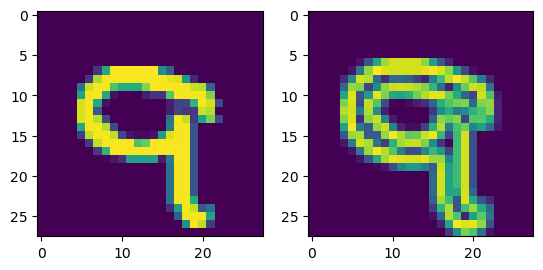

In [317]:
fig, axes = plt.subplots(ncols=2, nrows=1)
axes[0].imshow(image[1, 0])
axes[1].imshow(filtered_image[1, 0])

In [318]:
train(model, train_loader, optimizer, criterion, num_epochs)

Epoch 1 loss: 1.1289241716805807
Epoch 2 loss: 0.7119204400699022
Epoch 3 loss: 0.6963041610300922
Epoch 4 loss: 0.6700644854035205
Epoch 5 loss: 0.6688586367981266
Epoch 6 loss: 0.6537583716896805
Epoch 7 loss: 0.6463723829560188
Epoch 8 loss: 0.6459144961351017


In [309]:
x = next(enumerate(train_loader))[1]

In [310]:
with torch.no_grad():
    test_x  = model(x[0][1, :])[0]

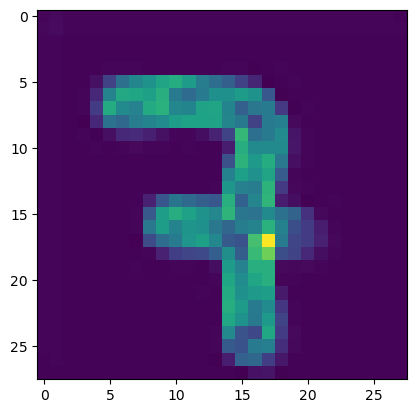

In [311]:
plt.imshow(test_x)

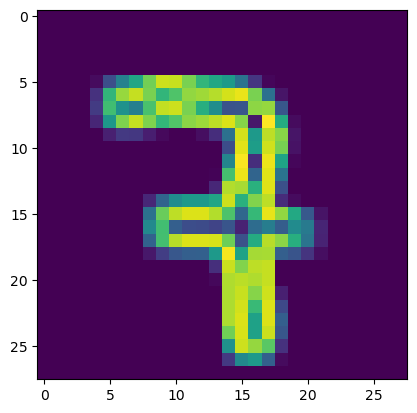

In [313]:
plt.imshow(x[1][1, 0])

In [241]:
x[1][1, 0].shape

torch.Size([28, 28])

(array([470.,  19.,  22.,  22., 115.,  17.,  18.,  26.,  28.,  47.]),
 array([0.        , 0.85521853, 1.71043706, 2.56565547, 3.42087412,
        4.27609253, 5.13131094, 5.98652935, 6.84174824, 7.69696665,
        8.55218506]),
 <BarContainer object of 10 artists>)

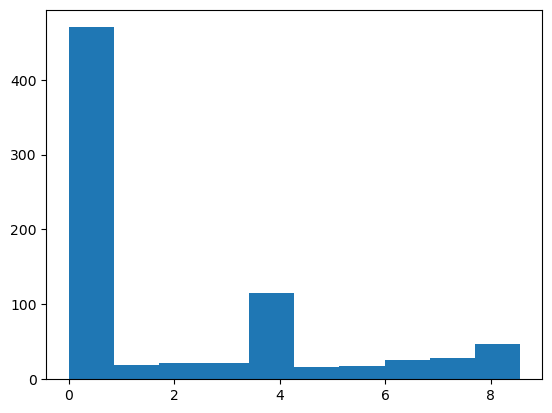

In [207]:
plt.hist(x[1][1, 0].numpy().flatten())

(array([  0.,   0.,   0.,   0.,   0., 784.,   0.,   0.,   0.,   0.]),
 array([1.50225878, 1.6022588 , 1.70225883, 1.80225873, 1.90225875,
        2.00225878, 2.10225868, 2.20225883, 2.30225873, 2.40225887,
        2.50225878]),
 <BarContainer object of 10 artists>)

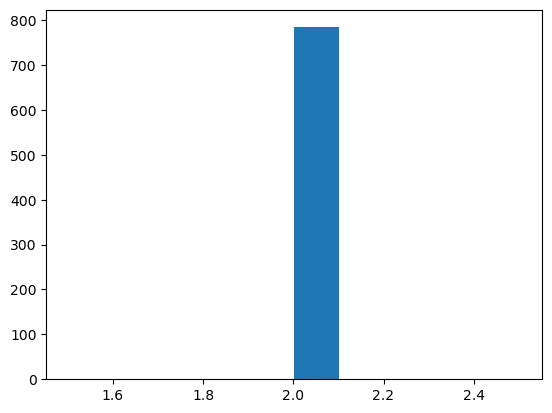

In [208]:
plt.hist(test_x.numpy().flatten())

In [274]:
image.shape

torch.Size([128, 1, 28, 28])

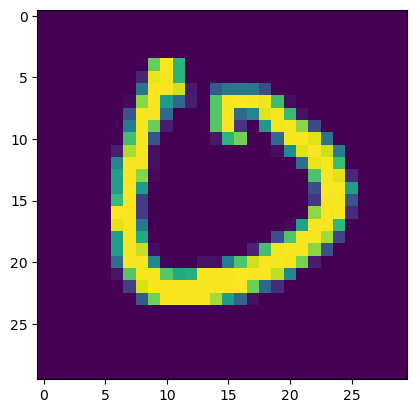

In [283]:
plt.imshow(torch.nn.functional.pad(image, (1, 1, 1, 1), mode="replicate")[0, 0])

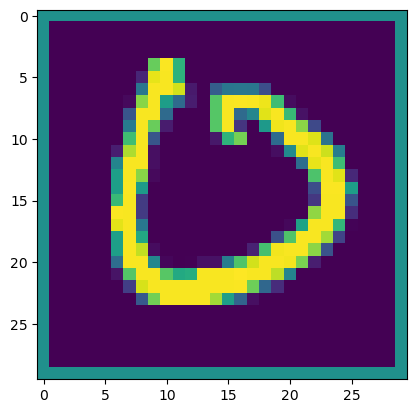

In [284]:
plt.imshow(torch.nn.functional.pad(image, (1, 1, 1, 1), mode="constant")[0, 0])